# Iterative method for OT-based registration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [28]:
import ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.io import loadmat
from scipy.ndimage import affine_transform
from sklearn.linear_model import LinearRegression

from otimage import imagerep, readers
from otimage.utils import plot_maxproj

In [35]:
def _ot_reg(pts_1, pts_2, wts_1, wts_2):
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
    M = M_nn / np.median(M_nn)

    # Compute transport plan
    p_mtx, ot_log = ot.emd(p_1, p_2, M, log=True)

    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(p_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = p_mtx[idx_1, idx_2]

    # Use sklearn.linear_model.LinearRegression to minimize cost function
    model = LinearRegression(fit_intercept=True)
    model.fit(x, y, sample_weight=smp_wt)

    # Estimates of transform parameters
    alpha = model.intercept_
    beta = model.coef_
    
    return alpha, beta, p_mtx, ot_log


def _compose_affine_maps(alphas, betas):
   
    alpha_comp = np.zeros(3)
    beta_comp = np.eye(3)
    
    for alpha, beta in zip(alphas, betas):
        
        alpha_comp = alpha + beta @ alpha_comp
        beta_comp = beta @ beta_comp
        
    return alpha_comp, beta_comp


def ot_reg_linear_2(pts_s, pts_t, wts_s, wts_t, n_iter):
    
    alpha = [None] * n_iter
    beta = [None] * n_iter
    p_mtx = [None] * n_iter
    ot_log = [None] * n_iter
    
    pts = [None] * (n_iter + 1)
    pts[0] = pts_s
    
    for i in range(n_iter):
        
        # Use OT regression to map current points to target points
        alpha[i], beta[i], p_mtx[i], ot_log[i] = _ot_reg(pts[i], pts_t, wts_s, wts_t)
        
        # Apply most recent mapping to points to get next set
        pts[i + 1] = alpha[i] + pts[i] @ beta[i].T
        
    alpha_comp, beta_comp = _compose_affine_maps(alpha, beta)
    
    debug = {
        'pts': pts,
        'alpha': alpha,
        'beta': beta,
        'p_mtx': p_mtx,
        'ot_log': ot_log,
    }
    
    return alpha_comp, beta_comp, debug

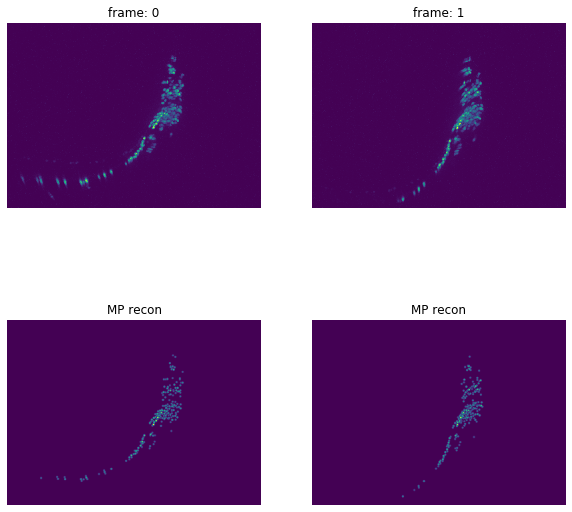

In [49]:
# Frame index
t1 = 0
t2 = t1 + 1

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts_1 = mp_data['means'][t1, :, :]
pts_2 = mp_data['means'][t2, :, :]
wts_1 = mp_data['weights'][t1, :, 0]
wts_2 = mp_data['weights'][t2, :, 0]

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

In [53]:
n_iter = 10

alpha, beta, debug = ot_reg_linear_2(pts_1, pts_2, wts_1, wts_2, n_iter)

print('alpha (est):')
print(alpha)
print('beta (est):')
print(beta)

alpha (est):
[303.83765344 -12.06352688   1.76062235]
beta (est):
[[ 0.46978561 -0.0105933  -0.96448275]
 [ 0.11873195  0.8423196   0.44007295]
 [ 0.02053894 -0.02651957  0.69474531]]


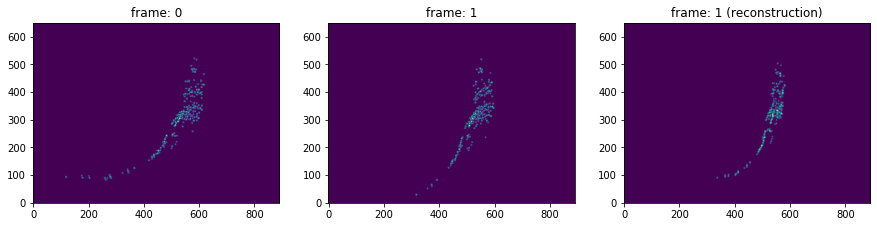

In [54]:
map_pts = (pts_1 @ beta.T + alpha).astype(int)
map_mp = imagerep.reconstruct_image_2(map_pts, wts_1, cov, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(map_mp)
plt.title(f'frame: {t2} (reconstruction)');

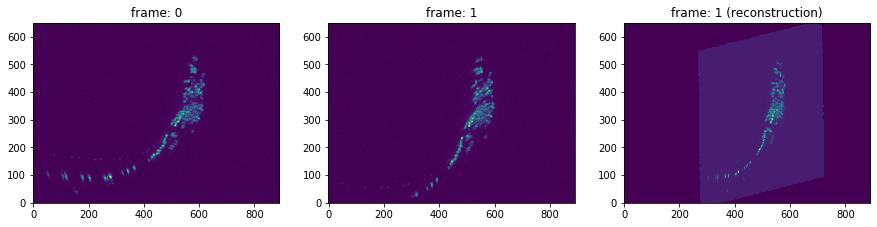

In [55]:
# Reconstruct A from B
inv_beta = np.linalg.inv(beta)
inv_alpha = -inv_beta @ alpha
map_img = affine_transform(img_1, inv_beta, inv_alpha)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(map_img)
plt.title(f'frame: {t2} (reconstruction)');

In [45]:
## TODO: Get this to work

#trans_rec = [imagerep.reconstruct_image(pts, [cov], wts_1, img_shape) for pts in debug['pts']]